In [49]:
import hopsworks
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import getpass

In [50]:
api_key = getpass.getpass(prompt="Enter your Hopsworks API key: ")

In [51]:
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/218261
Connected. Call `.close()` to terminate connection gracefully.


In [52]:
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name="wine",
    version=2,
    description="Read from Wine Quality dataset",
    labels=["quality"],
    query=query,
)

In [53]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using Hive (2.12s) 


In [54]:
df = pd.DataFrame(X_train)
df["quality"] = y_train

test_df = pd.DataFrame(X_test)
test_df["quality"] = y_test

wine_df = pd.concat([df, test_df])

In [55]:
wine_df.describe(include="all")

,volatile_acidity,chlorides,density,alcohol,quality
count,4972.000000,4972.000000,4972.000000,4972.000000,4972.000000
mean,0.338968,-2.999755,0.994483,10.542427,5.788817
std,0.158954,0.419210,0.002850,1.185048,0.885778
min,0.080000,-4.710531,0.987130,8.000000,3.000000
25%,0.230000,-3.270169,0.992200,9.500000,5.000000
50%,0.290000,-3.057608,0.994600,10.400000,6.000000
75%,0.400000,-2.733368,0.996700,11.400000,6.000000
max,0.980000,-1.305636,1.003690,14.200000,9.000000


In [56]:
wine_df.quality.value_counts()

quality
6    2113
5    1692
7     796
4     194
8     147
3      25
9       5
Name: count, dtype: int64

In [57]:
wine_df_3 = wine_df[wine_df.quality == 3]  # MINORITY
wine_df_4 = wine_df[wine_df.quality == 4]  # MINORITY
wine_df_5 = wine_df[wine_df.quality == 5]  # MAJORITY
wine_df_6 = wine_df[wine_df.quality == 6]  # MAJORITY
wine_df_7 = wine_df[wine_df.quality == 7]  # MINORITY
wine_df_8 = wine_df[wine_df.quality == 8]  # MINORITY

In [58]:
from sklearn.utils import resample

df_3_upsampled = resample(wine_df_3, replace=True, n_samples=1500, random_state=12)
df_4_upsampled = resample(wine_df_4, replace=True, n_samples=1500, random_state=12)
df_7_upsampled = resample(wine_df_7, replace=True, n_samples=1500, random_state=12)
df_8_upsampled = resample(wine_df_8, replace=True, n_samples=1500, random_state=12)

# Decreases the rows of Majority one's to make balance data :
df_5_downsampled = wine_df[wine_df.quality == 5].sample(n=1500).reset_index(drop=True)
df_6_downsampled = wine_df[wine_df.quality == 6].sample(n=1500).reset_index(drop=True)

In [59]:
Balanced_df = pd.concat(
    [
        df_3_upsampled,
        df_4_upsampled,
        df_7_upsampled,
        df_8_upsampled,
        df_5_downsampled,
        df_6_downsampled,
    ]
).reset_index(drop=True)


# Display new class counts
Balanced_df.quality.value_counts()

quality
3    1500
4    1500
7    1500
8    1500
5    1500
6    1500
Name: count, dtype: int64

In [60]:
X = Balanced_df.drop(columns="quality")
y = Balanced_df.quality

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

In [61]:
X_train.describe(include="all")

,volatile_acidity,chlorides,density,alcohol
count,7200.000000,7200.000000,7200.000000,7200.000000
mean,0.361241,-3.020123,0.994216,10.716383
std,0.181131,0.468543,0.002952,1.289320
min,0.080000,-4.710531,0.987130,8.000000
25%,0.240000,-3.324236,0.991720,9.700000
50%,0.310000,-3.101093,0.994050,10.500000
75%,0.440000,-2.780621,0.996590,11.700000
max,0.980000,-1.309333,1.003690,14.200000


In [62]:
from sklearn.neighbors import KNeighborsClassifier
## final model
model = KNeighborsClassifier(n_neighbors=5, weights="distance")
model.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [63]:
KNN_test_predictions = model.predict(X_test)

In [64]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n \n Test Data: KNN_Confusion Matrix: \n ")
print(confusion_matrix(y_test, KNN_test_predictions))

print("\n Test Data: KNN_Classification Report:\n ")
print(classification_report(y_test, KNN_test_predictions))


 
 Test Data: KNN_Confusion Matrix: 
 
[[301   0   0   0   0   0]
 [  0 311   0   0   0   0]
 [  1  58 139  68  35   8]
 [  6  26  64  82  59  18]
 [  0   4   3  23 260  11]
 [  0   0   0   0   0 323]]

 Test Data: KNN_Classification Report:
 
              precision    recall  f1-score   support

           3       0.98      1.00      0.99       301
           4       0.78      1.00      0.88       311
           5       0.67      0.45      0.54       309
           6       0.47      0.32      0.38       255
           7       0.73      0.86      0.79       301
           8       0.90      1.00      0.95       323

    accuracy                           0.79      1800
   macro avg       0.76      0.77      0.75      1800
weighted avg       0.76      0.79      0.77      1800



In [65]:


# rf = RandomForestRegressor(n_estimators=100)
# rf.fit(X_train, y_train.values.ravel())

In [66]:
# y_pred = rf.predict(X_test)

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"RF RMSE: {rmse}")

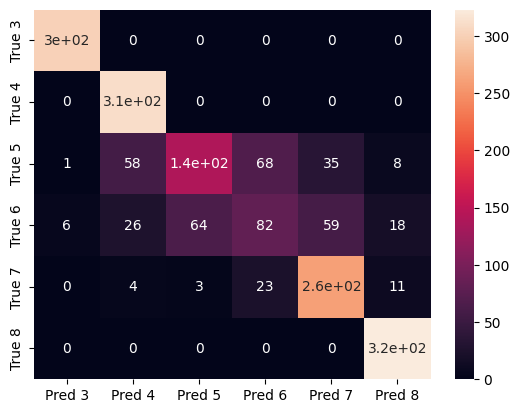

In [67]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
results = confusion_matrix(y_test, KNN_test_predictions)
df_cm = pd.DataFrame(
    results,
    ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8"],
    ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8"],
)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [69]:
metrics = classification_report(y_test, KNN_test_predictions, output_dict=True)
mr = project.get_model_registry()


model_dir = "wine_model"


if os.path.isdir(model_dir) == False:

    os.mkdir(model_dir)


joblib.dump(model, model_dir + "/wine_model.pkl")

fig.savefig(model_dir + "/confusion_matrix.png")


input_schema = Schema(X_train)

output_schema = Schema(y_train)

model_schema = ModelSchema(input_schema, output_schema)


wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy": metrics["accuracy"]},
    model_schema=model_schema,
    description="Wine Predictor"
)

wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 28524/28524 elapsed<00:01 remaining<00:001,  3.38it/s]
Uploading: 100.000%|██████████| 573542/573542 elapsed<00:02 remaining<00:00  3.38it/s]
Uploading: 100.000%|██████████| 501/501 elapsed<00:01 remaining<00:00<00:10,  2.50s/it]
Model export complete: 100%|██████████| 6/6 [00:11<00:00,  1.91s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/218261/models/wine_model/3


Model(name: 'wine_model', version: 3)